In [1]:
#!module load cuda

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm, trange

from datetime import datetime, timedelta

import seaborn as sns

In [9]:
class WeatherDataset(Dataset):
    def __init__(self, weather_data = 'data/big_arpafvg.csv', img_dir = 'data/cut_images'):
        initial_data=pd.read_csv(weather_data)
        initial_data = initial_data.drop(columns=['Temp. min gradi C','Temp. med gradi C','Temp. max gradi C','Vento med km/h','Dir. V. max gradi N'])
        #normalize the data
        for col in initial_data.columns:
            if col != 'giorno' and col != 'mese' and col != 'anno':
                initial_data[col] = (initial_data[col] - initial_data[col].mean()) / initial_data[col].std()
        self.weather_data = initial_data
        self.img_dir = img_dir
        self.seq_length = 7
        self.target_column_index = -1
        self.date_generated = []

    def __getitem__(self, date):
        #get day month year from date in format dd-mm-yyyy
        day, month, year = date.split('_')
        #get from weather data the row with the same date
        weather_data = self.weather_data[(self.weather_data['giorno'] == int(day)) & (self.weather_data['mese'] == int(month)) & (self.weather_data['anno'] == int(year))]
        weather_data = torch.tensor(weather_data.values[0])

        image = os.path.join(self.img_dir, str(date) + '.jpg')  
        image = read_image(image)   
        return [image, weather_data]
    
    def __len__(self):
        return len(self.weather_data)

    def date_generation(self, start_date, end_date):
        start_date = datetime.strptime(start_date, "%d_%m_%Y")
        end_date = datetime.strptime(end_date, "%d_%m_%Y")
        date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days)]
        #transform the list of datetime objects in a list of strings in format dd-mm-yyyy
        date_generated = [date.strftime("%d_%m_%Y") for date in date_generated]
        self.date_generated=date_generated
        return date_generated
    
    def create_sequence(self, date, len_seq):
        batch_xs =[]
        batch_imgs = []
        batch_ys = []
        for elem in date:
            ys = []
            end_of_week = elem.split('_')
            end_of_week = datetime(int(end_of_week[2]), int(end_of_week[1]), int(end_of_week[0])) + timedelta(days = len_seq)
            end_of_week = end_of_week.strftime("%d_%m_%Y")
            imgs, xs =[], []
            week=self.date_generation(elem,end_of_week)
            for day in week:
                a , b = self.__getitem__(day)
                imgs.append(a)
                xs.append(b)


            next = end_of_week.split('_')
            next = datetime(int(next[2]), int(next[1]), int(next[0])) + timedelta(days = 1)
            next = next.strftime("%d_%m_%Y")
            ys.append(self.__getitem__(next)[1][self.target_column_index])
            imgs = np.array(imgs)
            xs = np.array(xs)
            ys = np.array(ys)
            imgs = torch.from_numpy(imgs).float()
            xs = torch.from_numpy(xs).float()
            ys = torch.from_numpy(ys).float()
            batch_xs.append(xs)
            batch_imgs.append(imgs)
            batch_ys.append(ys)
                    
        batch_xs = np.array(batch_xs)
        batch_imgs = np.array(batch_imgs)
        batch_ys = np.array(batch_ys)
        batch_xs = torch.from_numpy(batch_xs).float()
        batch_imgs = torch.from_numpy(batch_imgs).float()
        batch_ys = torch.from_numpy(batch_ys).float()
        return batch_imgs, batch_xs, batch_ys

In [10]:
dataset = WeatherDataset()

In [11]:
#generate a list of strings dd-mm-yyyy from 01-06-2023 to 15-6-2024
dataset.date_generation("01_01_2022", "08_06_2024")
date_generated = dataset.date_generated


In [12]:
train_len = int(0.8 * len(dataset.date_generated))
test_len = len(dataset.date_generated) - train_len
#split the dataset: date_trainset contains the first 80% of the dates, date_testset contains the remaining 20%
date_trainset = date_generated[:train_len]
date_testset = date_generated[train_len:]

In [13]:
train_loader = torch.utils.data.DataLoader(date_trainset, batch_size = 4, shuffle = True)
test_loader = torch.utils.data.DataLoader(date_testset, batch_size = 4, shuffle = True)

In [14]:
class DeepWeather(nn.Module):
    def __init__(self):
        super(DeepWeather, self).__init__()

        self.conv1 = nn.Conv3d(in_channels=7, out_channels=32, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), padding=(0, 1, 1))
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.conv3 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn3 = nn.BatchNorm3d(128)
        self.conv4 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn4 = nn.BatchNorm3d(256)
        self.conv5 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn5 = nn.BatchNorm3d(512)
        self.conv6 = nn.Conv3d(in_channels=512, out_channels=1024, kernel_size=(1, 3, 3), stride=1, padding=(0, 1, 1))
        self.bn6 = nn.BatchNorm3d(1024)

        self.lstm = nn.LSTM(input_size=73728, hidden_size=50, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(50, 64)
        
        self.input_size = 10  
        self.hidden_size = 64
        self.num_layers = 2
        self.output_size = 64
        self.rnn2 = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(64 + 64, 1)  

    def forward(self, x1, x2):
        
        x1 = self.bn1(self.dropout(self.pool(F.leaky_relu(self.conv1(x1)))))
        x1 = self.bn2(self.dropout(self.pool(F.leaky_relu(self.conv2(x1)))))
        x1 = self.bn3(self.dropout(self.pool(F.leaky_relu(self.conv3(x1)))))
        x1 = self.bn4(self.dropout(self.pool(F.leaky_relu(self.conv4(x1)))))
        x1 = self.bn5(self.dropout(self.pool(F.leaky_relu(self.conv5(x1)))))
        x1 = self.bn6(self.dropout(self.pool(F.leaky_relu(self.conv6(x1)))))

        x1 = x1.transpose(1, 2) 
        x1 = torch.flatten(x1, start_dim=2)
        
        x1, (hn, cn) = self.lstm(x1)
        x1 = self.fc1(x1[:, -1, :])  # Prendi solo l'ultimo output della LSTM

        h0 = torch.zeros(self.num_layers, x2.size(0), self.hidden_size).to(x2.device)
        out, _ = self.rnn2(x2, h0)
        
        out = torch.cat((out[:, -1, :], x1), dim=1)  # Concatenazione corretta
        out = self.fc(out)

        return out

In [9]:
def train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = model.to(device)    
    
    train_loss_epochs = []
    test_loss_epochs = []
    bar = trange(epochs, desc=f"Epoch ?/?, Train Loss: ?, Test Loss: ?")
    for epoch in bar:
        model.train()
        train_losses = []
            
        for date in train_loader:
            imgs, xs, ys = dataset.create_sequence(date, 7)
            imgs = imgs.to(device)
            xs = xs.to(device)
            ys = ys.to(device)

            optimizer.zero_grad()
            outputs = model(imgs, xs)
            loss = criterion(outputs, ys)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            
        train_loss_epochs.append(np.mean(train_losses))
        model.eval()
        test_losses = []
        for date in test_loader:
            
            imgs, xs, ys = dataset.create_sequence(date, 7)
            imgs = imgs.to(device)
            xs = xs.to(device)
            ys = ys.to(device)
            outputs = model(imgs, xs)
            loss = criterion(outputs.squeeze(), ys)
            test_losses.append(loss.item())
                
        test_loss_epochs.append(np.mean(test_losses))
        bar.set_description(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses)}, Test Loss: {np.mean(test_losses)}")

    return train_loss_epochs, test_loss_epochs

In [15]:
model = DeepWeather()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 10e-6, weight_decay=1e-5)


In [11]:
#train_losses, val_losses = train(model, dataset, train_loader, test_loader, criterion, optimizer, epochs = 50, first_time = True, num_saved_epochs = 0)
#torch.save(model.state_dict(), "models_log_rain/model_cnn_lstm_rnn.tensor")

Epoch ?/?, Train Loss: ?, Test Loss: ?:   0%|                                                    | 0/50 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:605: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv3d(
/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2, 1])) that is diffe

In [16]:
state_dict=torch.load("models_log_rain/model_cnn_lstm_rnn.tensor")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [17]:
epochs = [epoch for epoch in range(50)]
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='mediumaquamarine')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("plots_log_rain/3dcnn_lstm_rnn_nocut_loss.png")
plt.show()

NameError: name 'train_losses' is not defined

In [18]:
prediction_dataset = WeatherDataset()
prediction_dataset.date_generation('24_12_2023','08_06_2024')
week=prediction_dataset.date_generated
pred_loader=torch.utils.data.DataLoader(week, batch_size = 1, shuffle = False)

In [19]:
def predict(model, pred_loader, dataset):
    predictions=[]
    predicted_days=[]
    real_rains=[]
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model=model.to(device)
    for date in pred_loader:  
            imgs, xs, ys = dataset.create_sequence(date, 7)
            imgs = imgs.to(device)
            xs = xs.to(device)
            ys = ys.to(device)
            output = model(imgs, xs)
            output=output.cpu()
            predictions.append(output.detach().numpy())
            predicted_day = date[0].split('_')
            predicted_day = datetime(int(predicted_day[2]), int(predicted_day[1]), int(predicted_day[0])) + timedelta(days = 8)
            predicted_day = predicted_day.strftime("%d_%m_%Y")
            predicted_days.append(predicted_day)
            real_rain = dataset[predicted_day][1][-1]
            real_rains.append(real_rain)
            
    return predicted_days, predictions, real_rains

In [20]:
predicted_days, predictions, real_rain= predict(model, pred_loader, prediction_dataset)

/orfeo/cephfs/home/dssc/scarpene/jupyter/lib64/python3.9/site-packages/torch/nn/modules/conv.py:605: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv3d(


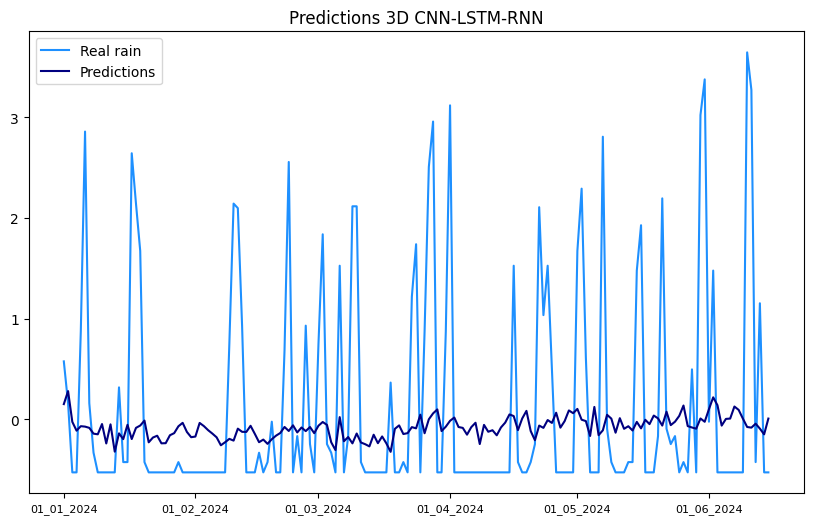

In [21]:
predicted_days = np.array(predicted_days)
real_rain = np.array(real_rain)

date_to_display = ['01_01_2024', '01_02_2024', '01_03_2024', '01_04_2024', '01_05_2024', '01_06_2024']

indices_to_display = [np.where(predicted_days == date)[0][0] for date in date_to_display if date in predicted_days]

plt.figure(figsize=(10, 6))
sns.lineplot(x=predicted_days, y=real_rain, label='Real rain', color='dodgerblue')
sns.lineplot(x=predicted_days, y=np.array(predictions).squeeze(), label='Predictions', color='navy')

plt.xticks(predicted_days[indices_to_display], date_to_display, fontsize=8)

plt.title('Predictions 3D CNN-LSTM-RNN')
plt.legend()
plt.savefig("plots_log_rain/3dcnn_lstm_rnn_nocut_pred.png")
plt.show()

In [24]:
mean_rain=np.mean(dataset.weather_data["log(Pioggia mm)"])
sd_rain=np.std(dataset.weather_data["log(Pioggia mm)"])


In [22]:
predictions = np.array(predictions).squeeze()

real_rain_tensor = torch.tensor(real_rain, dtype=torch.float32)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
rmse = torch.sqrt(mse_loss(predictions_tensor, real_rain_tensor))

print(f"RMSE: {rmse.item()}")

RMSE: 1.1044745445251465


In [28]:
priediction_non_norm= np.exp(predictions)*sd_rain+mean_rain

In [29]:
print(priediction_non_norm)

[1.1640356  1.3245051  0.97604686 0.89435005 0.93500215 0.93103355
 0.9196739  0.86815256 0.8626494  0.9550869  0.78772515 0.9521908
 0.72599995 0.87066966 0.8222024  0.94770473 0.8230308  0.919511
 0.9410647  0.9884313  0.79665285 0.8354744  0.85059816 0.7887205
 0.78992224 0.854629   0.8725644  0.9341753  0.96659535 0.8830211
 0.8381823  0.8435771  0.9655974  0.9357512  0.8986705  0.8688032
 0.8372174  0.7735912  0.7973895  0.8244731  0.81037986 0.9122994
 0.88412213 0.8833118  0.93865746 0.86658835 0.79754966 0.818624
 0.7845988  0.8215709  0.8510523  0.8739768  0.92787915 0.89144444
 0.9430496  0.8789051  0.9228746  0.89042    0.9273442  0.87228554
 0.9396514  0.9746495  0.94688815 0.7970838  0.7376301  1.0228988
 0.80532527 0.83964956 0.7883502  0.8693712  0.79524046 0.7820182
 0.7652387  0.85902345 0.7898894  0.8444084  0.7880322  0.7249292
 0.91069424 0.9424723  0.8649749  0.87264943 0.9262681  0.91529953
 1.0481019  0.8718024  1.0012519  1.0615819  1.1041169  0.89081275
 0.9305